# Predict if a customer will tip generously using Random Forest and XGBoost models
This notebook builds and evaluates Random Forest and XGBoost models to predict generous tippers based
on customer data. It includes hyperparameter tuning, cross-validation, and performance evaluation.

In this notebook we will explore thed data to find ways to generate more revenue for taxi cab drivers. 
Our model wil Identify whether a customers is a generous tipper 


## Feature Engineering

In [1]:
#  Imports 
import pandas as pd
import numpy as np  

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Model Selection 
from sklearn.model_selection import GridSearchCV, train_test_split

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier , plot_importance

# Evaluation Metrics (classification)
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Utilities
import warnings
warnings.filterwarnings("ignore")


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')
# NYC taxi fare predictions from the multiple linear regression model
nyc_preds_means = pd.read_csv('nyc_taxi_fare_predictions_mlr.csv')

In [4]:
nyc_preds_means.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mean_duration   22699 non-null  float64
 1   mean_distance   22699 non-null  float64
 2   predicted_fare  22699 non-null  float64
dtypes: float64(3)
memory usage: 532.1 KB


In [5]:
df0.head()
# print(df0.shape)
# print(nyc_preds_means.shape)
#print(df0.index)
#print(nyc_preds_means.index)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [6]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In [7]:
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


In [8]:
#merge the two dataframes on the index
df0 = df0.merge(nyc_preds_means, left_index=True, right_index=True)


In [9]:
df0.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


### Feature Engineering

We are trying to predict if a customer will be a generous tipper.

Here are the codes in the `payment_type` column:

| Code | Payment Type     |
|------|------------------|
| 0    | Flex Fare trip   |
| 1    | Credit card      |
| 2    | Cash             |
| 3    | No charge        |
| 4    | Dispute          |
| 5    | Unknown          |
| 6    | Voided trip      |


In [10]:
df0['payment_type'].value_counts()

payment_type
1    15265
2     7267
3      121
4       46
Name: count, dtype: int64

Average tip of customers that pay cash

In [11]:
# Calculate the mean tip amount of payments in cash ( payment_type=2)
mean_tip_cash = df0[df0['payment_type'] == 2]['tip_amount'].mean()
print(f"Mean tip amount for cash payments: {mean_tip_cash:.2f}")

Mean tip amount for cash payments: 0.00


Taxi drivers do not report the tips received from customers that pay cash.  In the data the tip for the 7,267 trips paid with cash is zero.
For this study I will consider only customers that pay with credit card. 

In [12]:
#create a dataframe with only the credit card payments  
df1 = df0[df0['payment_type'] == 1].copy()

In [13]:
df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount']- df1['tip_amount']),3)

In [14]:
df1.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200


We consider a generous tipper the customer that leaves a 20% tip or more.  Our target variable is "is a generos tipper or not "
### Generous tipper -> target variable

In [15]:
df1['generous'] = df1['tip_percent'] >= 0.20
#df1.head(5)
#in decision trees and random forest the target variable must be numeric
df1['generous'] = df1['generous'].astype(int)
#df1.head(5)

In [16]:
import datetime as dt
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

In [17]:
#create a day column
df1['day'] = pd.to_datetime(df1['tpep_pickup_datetime']).dt.day_name().str.lower()

We will classify the time of the day when the client was picked up. 

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  


In [18]:
#df1['tpep_pickup_datetime'].head()
df1['pickup_hour'] = df1['tpep_pickup_datetime'].dt.hour
df1['month'] = df1['tpep_pickup_datetime'].dt.month_name().str.lower()

df1[['pickup_hour', 'month']].head()

,pickup_hour,month
0,8,march
1,14,april
2,7,december
3,13,may
5,20,march


In [19]:
#Enginneer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:
df1['am_rush']   = ((df1['pickup_hour'] >= 6)  & (df1['pickup_hour'] < 10)).astype(int)
df1['daytime']   = ((df1['pickup_hour'] >= 10) & (df1['pickup_hour'] < 16)).astype(int)
df1['pm_rush']   = ((df1['pickup_hour'] >= 16) & (df1['pickup_hour'] < 20)).astype(int)
df1['nighttime'] = ((df1['pickup_hour'] >= 20) | (df1['pickup_hour'] < 6)).astype(int)

df1.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,pickup_hour,month,am_rush,daytime,pm_rush,nighttime
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,8,march,1,0,0,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,14,april,0,1,0,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,7,december,1,0,0,0
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,13,may,0,1,0,0
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,20,march,0,0,0,1


In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             15265 non-null  int64         
 1   VendorID               15265 non-null  int64         
 2   tpep_pickup_datetime   15265 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  15265 non-null  datetime64[ns]
 4   passenger_count        15265 non-null  int64         
 5   trip_distance          15265 non-null  float64       
 6   RatecodeID             15265 non-null  int64         
 7   store_and_fwd_flag     15265 non-null  object        
 8   PULocationID           15265 non-null  int64         
 9   DOLocationID           15265 non-null  int64         
 10  payment_type           15265 non-null  int64         
 11  fare_amount            15265 non-null  float64       
 12  extra                  15265 non-null  float64       
 13  mta_ta

Selection of columns for modeling:  we will drop the unnecesary columns.

In [21]:
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'pickup_hour' , 'store_and_fwd_flag',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)

In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  month            15265 non-null  object 
 11  am_rush          15265 non-null  int64  
 12  daytime          15265 non-null  int64  
 13  pm_rush          15265 non-null  int64  
 14  nighttime        15265 non-null  int64  
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


In [23]:
df1.head()

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,mean_duration,mean_distance,predicted_fare,generous,day,month,am_rush,daytime,pm_rush,nighttime
0,2,6,1,100,231,22.847222,3.521667,16.434245,1,saturday,march,1,0,0,0
1,1,1,1,186,43,24.470370,3.108889,16.052218,1,tuesday,april,0,1,0,0
2,1,1,1,262,236,7.250000,0.881429,7.053706,0,friday,december,1,0,0,0
3,2,1,1,188,97,30.250000,3.700000,18.731650,1,sunday,may,0,1,0,0
5,2,6,1,161,236,11.855376,2.052258,10.441351,1,saturday,march,0,0,0,1


## variable Encoding
The categorical variables are:
VendorID: 
1=Creative Mobile Technologies, LLC
2=VeriFone Inc.

RatecodeID: 
1 = standard rate  
2 = JFK (airport)  
3 = Newark (airport)  
4 = Nassau or Westchester  
5 = Negotiated fare  
6 = Group ride  

PULocationID: TLC Taxi Zone in which the taximeter was engaged
DOLocationID: TLC Taxi Zone in which the taximeter was desengaged

In [24]:
df1['PULocationID'].value_counts().unique()
df1['DOLocationID'].value_counts().unique()

array([549, 531, 490, 489, 487, 442, 414, 389, 385, 364, 363, 348, 343,
       339, 329, 307, 305, 301, 299, 293, 286, 265, 263, 255, 246, 230,
       225, 207, 206, 192, 187, 182, 181, 178, 174, 160, 157, 156, 155,
       141, 136, 121, 117, 108,  87,  82,  77,  75,  69,  67,  66,  61,
        54,  50,  47,  46,  44,  43,  42,  38,  37,  35,  33,  32,  31,
        30,  28,  26,  24,  23,  21,  17,  16,  15,  13,  12,  11,  10,
         9,   8,   7,   6,   5,   4,   3,   2,   1])

In [25]:
#convert the categorical columns to string type
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  object 
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  object 
 3   PULocationID     15265 non-null  object 
 4   DOLocationID     15265 non-null  object 
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  month            15265 non-null  object 
 11  am_rush          15265 non-null  int64  
 12  daytime          15265 non-null  int64  
 13  pm_rush          15265 non-null  int64  
 14  nighttime        15265 non-null  int64  
dtypes: float64(3), int64(6), object(6)
memory usage: 1.9+ MB


In [26]:
cat_cols = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'day', 'month']
df_encoded = pd.get_dummies(df1, columns=cat_cols, drop_first=True)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to month_september
dtypes: bool(338), float64(3), int64(6)
memory usage: 6.1 MB


Before modeling let's check the balance of the target variable

In [27]:
df_encoded['generous'].value_counts(normalize=True)

generous
1    0.526368
0    0.473632
Name: proportion, dtype: float64

The dataset is balance (almost 50-50).  To evaluate the model i will use F1 score that places equal weight on precision and recall

In [28]:
y = df_encoded['generous']
X = df_encoded.drop('generous', axis=1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Random Forest Modeling

In [29]:
# Instantiate the Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

cv_params = {'max_depth': [None, 10,20],
             'max_features': [1.0, 'sqrt', 'log2'],
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,5],
             'n_estimators': [200,300]
             }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. setup grid search parameters
rf1 = GridSearchCV(
    estimator=rf,
    param_grid= cv_params,
    cv=4,                     
    scoring= scoring,
    refit='f1',  # Use F1 score to refit the model       
    n_jobs=-1,
    verbose=2
)




In [ ]:
%%time
### 5. Fit the model
#rf1.fit(X_train, y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
CPU times: total: 4.16 s
Wall time: 5min 36s


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': [1.0, 'sqrt', ...], 'max_samples': [0.7], 'min_samples_leaf': [1, 2], ...}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,-1
,refit,'f1'
,cv,4
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


## Pickle the model
### GridSearchCV Model for model metrics
### Best Estimator for predictions/deployment

In [31]:
import pickle
# Save full GridSearchCV for score tracking
# pickle.dump(rf1, open('rf1_model_full.pkl', 'wb'))

# # Save only best estimator for deployment or predictions
# pickle.dump(rf1.best_estimator_, open('best_rf_model.pkl', 'wb'))



### Load the full GridSearchCV Model for score tracking

In [32]:
# Load GridSearchCV object
with open('rf1_model_full.pkl', 'rb') as f:
    grid_rf = pickle.load(f)

# Now you can access:
print("Best score (CV):", grid_rf.best_score_)
print("Best parameters:", grid_rf.best_params_)

Best score (CV): 0.7498631897375969
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [33]:
# Load only the best fitted RandomForestClassifier
with open('best_rf_model.pkl', 'rb') as f:
    best_rf = pickle.load(f)

### grid_rf is the GridSearchCV object

In [34]:
# Get CV results
cv_results = pd.DataFrame(grid_rf.cv_results_)

# Pick best row based on F1 score (or any other)
best_idx = cv_results['mean_test_f1'].idxmax()
best_row = cv_results.iloc[best_idx]

# Extract metrics
f1 = best_row['mean_test_f1']
recall = best_row['mean_test_recall']
precision = best_row['mean_test_precision']
accuracy = best_row['mean_test_accuracy']

# Make table
rf_cv_scores = pd.DataFrame({
    'model': ['RF CV'],
    'precision': [precision],
    'recall': [recall],
    'F1': [f1],
    'accuracy': [accuracy]
})

print(rf_cv_scores)

   model  precision    recall        F1  accuracy
0  RF CV   0.689046  0.822495  0.749863  0.711186


This is an acceptable model across the board. Typically scores of 0.65 or better are considered acceptable, but this is always dependent on your use case. Optional: try to improve the scores. It's worth trying, especially to practice searching over different hyperparameters.

### Prediction on test data

In [ ]:
# Prediction on the training set - random forest
y_pred = best_rf.predict(X_test)

In [36]:
#evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Make table
rf_results = pd.DataFrame({
    'model': ['Random Forest'],
    'precision': [precision],
    'recall': [recall],
    'F1': [f1],
    'accuracy': [accuracy]
})
print(rf_results)

           model  precision    recall        F1  accuracy
0  Random Forest   0.681256  0.823273  0.745562  0.704225


In [37]:
def get_test_scores(model_name, y_pred, y_true):
    '''
    Returns a one-row dataframe with precision, recall, F1, and accuracy.
    '''
    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)

    return pd.DataFrame({
        'model': [model_name],
        'precision': [precision],
        'recall': [recall],
        'F1': [f1],
        'accuracy': [accuracy]
    })


In [38]:
# Get test results as a DataFrame

rf_test_scores = get_test_scores('RF test', y_pred, y_test)

# Combine with cross-validation scores
combined_results = pd.concat([rf_cv_scores, rf_test_scores], axis=0, ignore_index=True)

# Display
print(combined_results)


     model  precision    recall        F1  accuracy
0    RF CV   0.689046  0.822495  0.749863  0.711186
1  RF test   0.681256  0.823273  0.745562  0.704225


My prediction with the test data is a little worst than the crossvalidation results.  

## XGBoost Modeling

In [39]:
# Instantiate the XGBoost Classifier
xgb = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    random_state=0,
    n_jobs=-1,
    use_label_encoder=False,  # Avoid warning about label encoder
    eval_metric='logloss'  # Set evaluation metric
)

cv_params = {'n_estimators': [100,300],
             'learning_rate': [0.01, 0.1],
             'max_depth': [4,6,8],
             'min_child_weight': [1,2]
             }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. setup grid search parameters
xgb1 = GridSearchCV(
    estimator=xgb,
    param_grid= cv_params,
    cv=4,                     
    scoring= scoring,
    refit='f1',  # Use F1 score to refit the model       
    n_jobs=-1,
    verbose=2
)

In [ ]:
#train the model
%%time
#xgb1.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
CPU times: total: 7.17 s
Wall time: 15.6 s


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1], 'max_depth': [4, 6, ...], 'min_child_weight': [1, 2], 'n_estimators': [100, 300]}"
,scoring,"['accuracy', 'precision', ...]"
,n_jobs,-1
,refit,'f1'
,cv,4
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [41]:
import pickle
# Save full GridSearchCV for score tracking
# pickle.dump(xgb1, open('xgb_model_full.pkl', 'wb'))

# # # Save only best estimator for deployment or predictions
# pickle.dump(xgb1.best_estimator_, open('best_xgb_model.pkl', 'wb'))


In [53]:
# Load GridSearchCV object
with open('xgb_model_full.pkl', 'rb') as f:
    grid_xgb = pickle.load(f)


In [55]:
print("Best score (CV):", grid_xgb.best_score_)
print("Best parameters:", grid_xgb.best_params_)

Best score (CV): 0.7476342691983768
Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300}


grid_xgb is my GridSearchCV object

In [56]:
#Get the CV results
xgb_cv_score = pd.DataFrame({
    'model': ['XGB CV'],
    'precision': [grid_xgb.cv_results_['mean_test_precision'][grid_xgb.best_index_]],
    'recall':    [grid_xgb.cv_results_['mean_test_recall'][grid_xgb.best_index_]],
    'F1':        [grid_xgb.cv_results_['mean_test_f1'][grid_xgb.best_index_]],
    'accuracy':  [grid_xgb.cv_results_['mean_test_accuracy'][grid_xgb.best_index_]]
})
xgb_cv_score

,model,precision,recall,F1,accuracy
0,XGB CV,0.693889,0.810516,0.747634,0.712005


In [48]:
# Load only the best fitted XGBClassifier
with open('best_xgb_model.pkl', 'rb') as f:
    best_xgb = pickle.load(f)

In [57]:
#Prediction on the training set
y_pred_xgb_train = best_xgb.predict(X_train)

In [58]:
xgb_test_scores = get_test_scores('XGB CV test', y_pred_xgb, y_test)

In [59]:
# Combine with cross-validation scores
combined_results = pd.concat([rf_cv_scores, rf_test_scores,xgb_cv_score, xgb_test_scores], axis=0, ignore_index=True)

# Display
print(combined_results)

         model  precision    recall        F1  accuracy
0        RF CV   0.689046  0.822495  0.749863  0.711186
1      RF test   0.681256  0.823273  0.745562  0.704225
2       XGB CV   0.693889  0.810516  0.747634  0.712005
3  XGB CV test   0.684595  0.815806  0.744463  0.705208


Highest F1 Score:
The F1 score for the Random Forest on both the cross-validation set (0.7499) and test set (0.7456) is slightly higher than XGBoost, indicating better balance between precision and recall.

Consistent Performance:
The Random Forest showed stable scores across both cross-validation and test sets, showing it generalized well without overfitting.

## Confusion Matrix
I will use the random forest since it gives me the highest F1 score

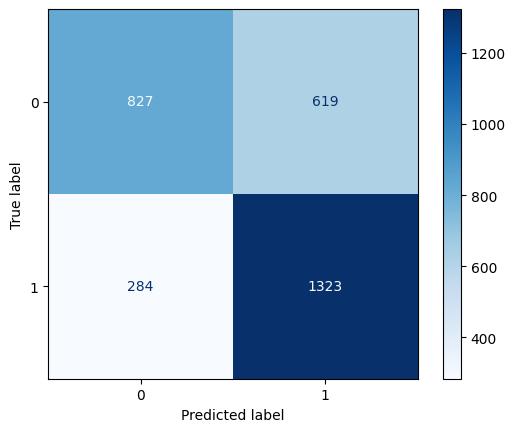

In [60]:
#confusion matrix
cm = confusion_matrix(y_true= y_test, y_pred=  y_pred , labels=best_rf.classes_)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
display.plot(cmap=plt.cm.Blues)

The model corrected predicted 1323 true positives 
The model corrected predicted 827 true negatives.
The false negative rate (284 missed actual positives) is lower than the false positive rate, which  make the model suitable since positives (generous tippers) is more important than avoiding false alarms.

## Feature importances
    

In [62]:
#find the more important features
importances = best_rf.feature_importances_
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)
# Display feature importances
top_features = feature_importances.head(10)
print(top_features)


              feature  importance
8          VendorID_2    0.209486
0     passenger_count    0.086104
3      predicted_fare    0.085722
1       mean_duration    0.067384
2       mean_distance    0.063807
36   PULocationID_138    0.013487
9        RatecodeID_2    0.013131
168  DOLocationID_138    0.012801
6             pm_rush    0.011816
5             daytime    0.010535


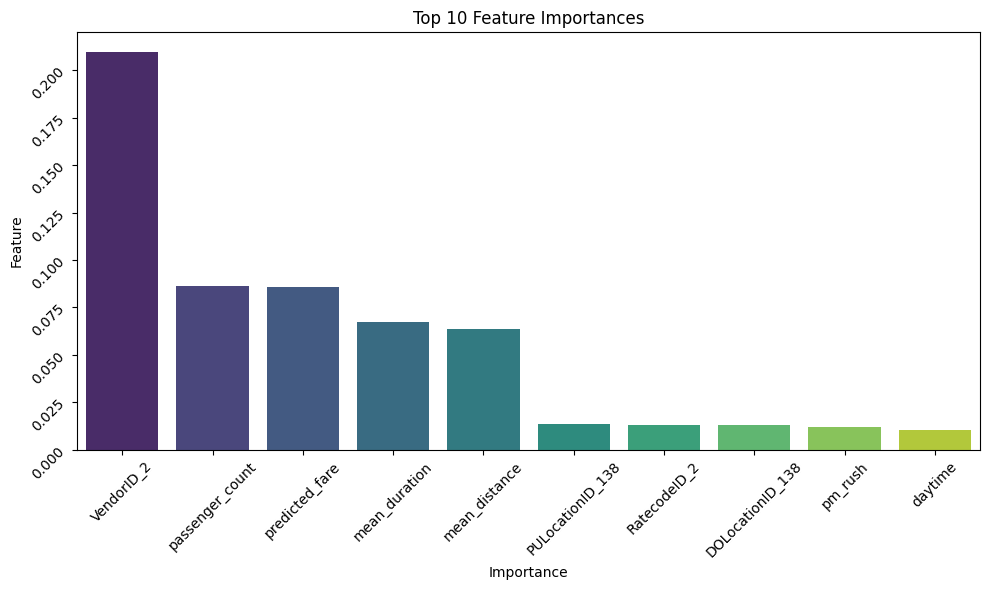

In [67]:
#plot a bar chart of the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='feature', y='importance', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10, rotation=45)

plt.tight_layout()
plt.show()
